1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



The guess for the maximum wind speed occurring every 50 years is 32.980 m/s


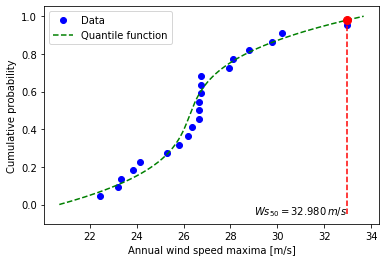

In [1]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

%matplotlib inline 

max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
# building cprob array as the definition
cprob = np.array([i/(years_nb + 1) for i in range(1,years_nb+1,1)])
sort_speeds = np.sort(max_speeds)
#quantile function
quantile_func = UnivariateSpline(cprob, sort_speeds)
fifty_prob = 1. - 0.02
fifty_wind = quantile_func(fifty_prob)
#points to plot the function
y = np.linspace(0,1,200)
quant_y = quantile_func(y)
print("The guess for the maximum wind speed occurring every 50 years is %.3f m/s" % fifty_wind)
#making the plot
plt.plot(sort_speeds, cprob, 'bo', label='Data')
plt.plot(quant_y, y, 'g--', label='Quantile function')
plt.plot(fifty_wind, fifty_prob, 'o', ms=8., mfc='r', mec='r')
plt.text(29, -0.05, '$Ws_{50} = %.3f \, m/s$' % fifty_wind)
plt.plot([fifty_wind, fifty_wind], [plt.axis()[2], fifty_prob], 'r--')
plt.xlabel('Annual wind speed maxima [m/s]')
plt.ylabel('Cumulative probability')
plt.legend(loc='best')
plt.show()

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

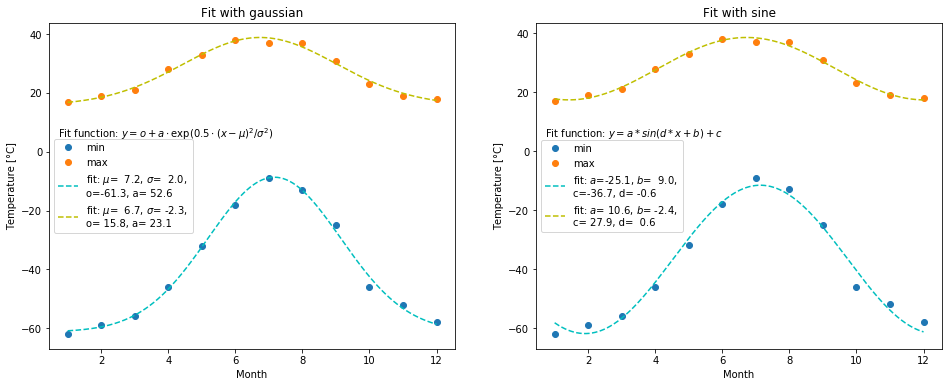

Both fits seem reasonable. For a more in-depth analysis residuals should be considered. 
Even though the behaviour would be naively expected to be periodical, a gaussian function seems to better fit the minima. 
Within the fit accuracy, the max for the temeperature occurs 15 days before the min.


In [2]:
import math as m
from scipy.optimize import curve_fit

#data
maxima = np.array([17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
minima = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
nmonths = maxima.shape[0]
x = np.arange(1, nmonths +1, 1)
#plot of data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax1.plot(x, minima, 'o', label='min')
ax1.plot(x, maxima, 'o', label='max')
ax1.set_xlabel('Month')
ax1.set_ylabel('Temperature [°C]')
#definition of the functions
def gauss(x, mean, sigma, offset, amplitude):
    return np.array([offset + amplitude*m.exp(-0.5*np.power((float(i)-float(mean))/sigma, 2.)) for i in x])
def sine(x, a, b, c, d):
    return np.array([a*m.sin(d*i+b)+c for i in x])
#fitting to the data
popt_max, pcov_max = curve_fit(gauss, x, maxima)
popt_min, pcov_min = curve_fit(gauss, x, minima, p0=[7.,2.,-60.0, 10])
x_days = np.linspace(1,12,365)
ax1.text(0.7, 5, r'Fit function: $y = o + a \cdot \exp(0.5\cdot (x-\mu)^2/\sigma^2)$')
ax1.plot(x_days, gauss(x_days, *popt_min), 'c--', label='fit: $\mu$=%5.1f, $\sigma$=%5.1f, \no=%5.1f, a=%5.1f' % tuple(popt_min))
ax1.plot(x_days, gauss(x_days, *popt_max), 'y--', label='fit: $\mu$=%5.1f, $\sigma$=%5.1f, \no=%5.1f, a=%5.1f' % tuple(popt_max))
ax1.set_title('Fit with gaussian')
ax1.legend(loc='best')
ax2.plot(x, minima, 'o', label='min')
ax2.plot(x, maxima, 'o', label='max')
ax2.set_xlabel('Month')
ax2.set_ylabel('Temperature [°C]')
popt_max, pcov_max = curve_fit(sine, x, maxima, p0=[10,0,-30,0])
popt_min, pcov_min = curve_fit(sine, x, minima, p0=[-20,0,40,0])
ax2.text(0.7, 5, r'Fit function: $y = a*sin(d*x+b)+c$')
ax2.plot(x_days, sine(x_days, *popt_min), 'c--', label='fit: $a$=%5.1f, $b$=%5.1f, \nc=%5.1f, d=%5.1f' % tuple(popt_min))
ax2.plot(x_days, sine(x_days, *popt_max), 'y--', label='fit: $a$=%5.1f, $b$=%5.1f, \nc=%5.1f, d=%5.1f' % tuple(popt_max))
ax2.set_title('Fit with sine')
ax2.legend(loc='best')
plt.show()
print("Both fits seem reasonable. For a more in-depth analysis residuals should be considered. \nEven though the behaviour would be naively expected to be periodical, a gaussian function seems to better fit the minima. \nWithin the fit accuracy, the max for the temeperature occurs 15 days before the min.")

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


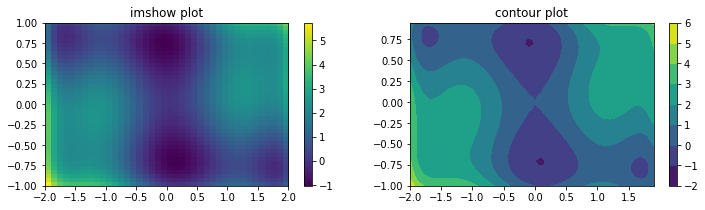

There are two globa minima:  [ 0.08984201 -0.71265641] and [-0.08984202  0.71265639] , where the function takes the value -1.0316284534898768
With an initial guess of (0,0) the algorithm finds the saddle point:  [0. 0.] , where the function takes the value 0.0


In [3]:
from scipy.optimize import minimize

#definition of the function
def f(params):
    x, y = params
    return (4.-2.1*x**2+x**4/3.)*x**2+x*y+(4.*y**2-4.)*y**2

#definition of meshgrid on which to evaluate f
x = np.arange(-2, 2, 0.1)
y = np.arange(-1, 1, 0.05)
xx, yy = np.meshgrid(x, y, sparse=True)

#plotting f with two tools
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
ax1.set_title("imshow plot")
g = ax1.imshow(f([xx,yy]), aspect='auto', origin='lower',extent=[-2, 2, -1, 1])
fig.colorbar(g, ax=ax1)
ax2.set_title("contour plot")
h = ax2.contourf(x,y, f([xx,yy]))
fig.colorbar(h, ax=ax2)
plt.show()

#finding global minima exploiting information from the plots
initial_guess = [[0.1, -0.75], [-0.1, 0.75]]
res_pm = minimize(f, initial_guess[0])
res_mp = minimize(f, initial_guess[1])
print("There are two globa minima: ", res_pm.x, "and", res_mp.x, ", where the function takes the value", f(res_pm.x))

#trying with initial guess of (0,0)
res_zz = minimize(f, (0,0))
print("With an initial guess of (0,0) the algorithm finds the saddle point: ", res_zz.x, ", where the function takes the value", f(res_zz.x))

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

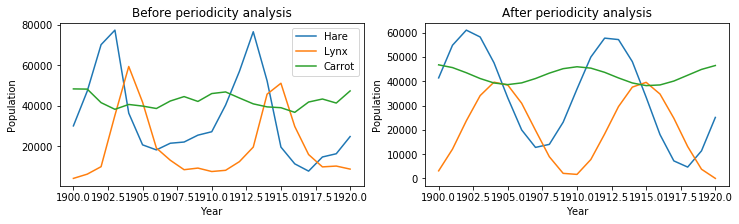

The period seems to be of approximately 10 years for each population


In [6]:
from scipy import fftpack

def period_analysis(x, y):
    sig_fft = fftpack.fft(y)
    power = np.abs(sig_fft)
    sample_freq = fftpack.fftfreq(x.size, d=1.0)
    pos_mask = np.where(np.abs(sample_freq) > 0)
    freqs = np.abs(sample_freq[pos_mask])
    peak_freq = freqs[power[pos_mask].argmax()]
    high_freq_fft = sig_fft.copy()
    high_freq_fft[np.abs(sample_freq) > peak_freq] = 0.
    filtered_sig = fftpack.ifft(high_freq_fft)
    ax2.plot(x, filtered_sig)

#loading data
dataLH = np.loadtxt('populations.txt')
year, hares, lynxes, carrots = dataLH.T

#plotting data before and after periodicity analysis
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
pl1 = ax1.plot(year, hares, year, lynxes, year, carrots) 
leg1 = ax1.legend(('Hare', 'Lynx', 'Carrot'), loc='best')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population')
title1 = ax1.set_title("Before periodicity analysis")
period_analysis(year, hares)
period_analysis(year, lynxes)
period_analysis(year, carrots)
ax2.set_xlabel('Year')
ax2.set_ylabel('Population')
ax2.set_title("After periodicity analysis")
plt.show()
#inferring the periodicity from the plot
print("The period seems to be of approximately 10 years for each population")

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

It is difficult to visualise the spectrum since the noise flattens all the low frequency.


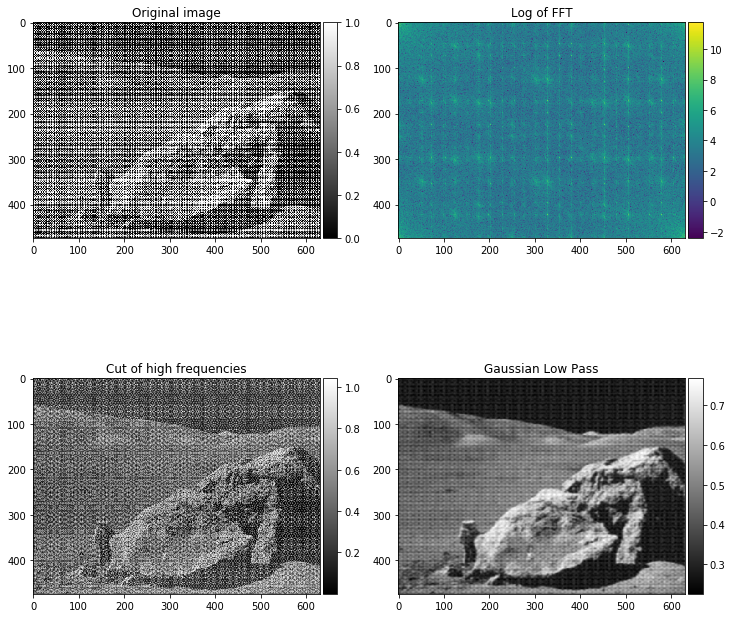

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

#importing and showing the picture
img = plt.imread('moonlanding.png')
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
ax1.set_title("Original image")
g = ax1.imshow(img, plt.cm.gray)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(g, cax=cax, orientation='vertical')

#performing the 2D fast fourier transform and showing the result
fimg = np.array(fftpack.fft2(img))
fimgab = np.abs(fimg)
ax2.set_title("Log of FFT")
h = ax2.imshow(np.log(fimgab))
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(h, cax=cax, orientation='vertical')
print("It is difficult to visualise the spectrum since the noise flattens all the low frequency.")

#custom cutting some of the high frequencies
cut = fimgab.mean() + 30.*fimgab.std()
filtered_sig = fimg.copy()
filtered_sig[(fimgab > cut) & (fimgab < (fimgab.max()-1.*fimgab.std()))] = 0
img2 = np.abs(fftpack.ifft2(filtered_sig))
ax3.set_title("Cut of high frequencies")
j = ax3.imshow(img2, plt.cm.gray)
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(j, cax=cax, orientation='vertical')

#alternative analysis with gaussian Low pass
def distance(point1,point2):
    return m.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def gaussianLP(D0,imgShape):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows/2,cols/2)
    for x in range(cols):
        for y in range(rows):
            base[y,x] = m.exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base

original = np.fft.fft2(img)
center = np.fft.fftshift(original)
LowPassCenter = center * gaussianLP(50,img.shape)
LowPass = np.fft.ifftshift(LowPassCenter)
inverse_LowPass = np.fft.ifft2(LowPass)
k = ax4.imshow(np.abs(inverse_LowPass), "gray")
ax4.set_title("Gaussian Low Pass")
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(k, cax=cax, orientation='vertical')

plt.show()